* [1.0 - Introduction](#1.0---Introduction)
    - [1.1 - Library imports and loading the data from SQL to pandas](#1.1---Library-imports-and-loading-the-data-from-SQL-to-pandas)
    
    
* [2.0 - Data Cleaning](#2.0---Data-Cleaning)
    - [2.1 - Pre-cleaning, investigating data types](#2.1---Pre-cleaning,-investigating-data-types)
    - [2.2 - Dealing with non-numerical values](#2.2---Dealing-with-non-numerical-values)
    
    
* [3 - Creating New Features](#)
    - [3.1 - Creating the 'gender' column](#3.1---Creating-the-'gender'-column)
    - [3.2 - Categorizing job titles](#3.2---Categorizing-job-titles)   
     

* [4.0 - Data Analysis and Visualizations](#4.0---Data-Analysis-and-Visualizations)
    - [4.1 - Overview of the gender gap](#4.1---Overview-of-the-gender-gap)    
    - [4.2 - Exploring the year column](#4.2---Exploring-the-year-column)
    - [4.3 - Full time vs. part time employees](#4.3---Full-time-vs.-part-time-employees)
    - [4.4 - Breaking down the total pay](#4.4---Breaking-down-the-total-pay)
    - [4.5 - Breaking down the base pay by job category](#4.5---Breaking-down-the-base-pay-by-job-category)    
    - [4.6 - Gender representation by job category](#4.6---Gender-representation-by-job-category)
    - [4.7 - Significance testing by exact job title](#4.7---Significance-testing-by-exact-job-title)
    

* [5.0 - San Francisco vs. Newport Beach](#5.0---San-Francisco-vs.-Newport-Beach)
    - [5.1 - Part time vs. full time workers](#5.1---Part-time-vs.-full-time-workers)  
    - [5.2 - Comparisons by job cateogry](#5.2---Comparisons-by-job-cateogry)  
    - [5.3 - Gender representation by job category](#5.3---Gender-representation-by-job-category)          
    
    
* [6.0 - Conclusion](#6.0---Conclusion)

    
    

### 1.0 - Introduction

In this project, I will focus on data analysis and visualization for the gender wage gap. Specifically, I am going to focus on public jobs in the city of San Francisco. This data set is publically available on [Kaggle](https://www.kaggle.com/kaggle/sf-salaries).  For a complete list of requirements and files used, check out my GitHub repository [here](https://github.com/sengkchu/Projects). 

The following questions will be explored:

+ Is there an overall gender wage gap for public jobs in San Francisco?
+ Is the gender gap really 78 cents on the dollar?
+ Is there a gender wage gap for full time employees?
+ Is there a gender wage gap for part time employees?
+ Is there a gender wage gap if the employees were grouped by job categories?
+ Is there a gender wage gap if the employees were grouped by exact job title?
+ If the gender wage gap exists, is the data statistically significant?
+ If the gender wage gap exists, how does the gender wage gap in San Francisco compare with more conservative cities in California?

Lastly, I want to mention that I am not affiliated with any political group, everything I write in this project is based on my perspective of the data alone.

#### 1.1 - Library imports and loading the data from SQL to pandas

The SQL database is about 18 megabytes, which is small enough for my computer to handle. So I've decided to just load the entire database into memory using pandas. However, I created a function that takes in a SQL query and returns the result as a pandas dataframe just in case I need to use SQL queries.

In [1]:
import pandas as pd
import numpy as np
import sqlite3
import matplotlib.pyplot as plt
import seaborn as sns
import gender_guesser.detector as gender
import time
import collections
%matplotlib inline
sns.set(font_scale=1.5)

def run_query(query):
    with sqlite3.connect('database.sqlite') as conn:
        return pd.read_sql(query, conn)

#Read the data from SQL->Pandas
q1 = '''
SELECT * FROM Salaries
'''

data = run_query(q1)
data.head()

,Id,EmployeeName,JobTitle,BasePay,OvertimePay,OtherPay,Benefits,TotalPay,TotalPayBenefits,Year,Notes,Agency,Status
0,1,NATHANIEL FORD,GENERAL MANAGER-METROPOLITAN TRANSIT AUTHORITY,167411,0,400184,,567595.43,567595.43,2011,,San Francisco,
1,2,GARY JIMENEZ,CAPTAIN III (POLICE DEPARTMENT),155966,245132,137811,,538909.28,538909.28,2011,,San Francisco,
2,3,ALBERT PARDINI,CAPTAIN III (POLICE DEPARTMENT),212739,106088,16452.6,,335279.91,335279.91,2011,,San Francisco,
3,4,CHRISTOPHER CHONG,WIRE ROPE CABLE MAINTENANCE MECHANIC,77916,56120.7,198307,,332343.61,332343.61,2011,,San Francisco,
4,5,PATRICK GARDNER,"DEPUTY CHIEF OF DEPARTMENT,(FIRE DEPARTMENT)",134402,9737,182235,,326373.19,326373.19,2011,,San Francisco,


### 2.0 - Data Cleaning

Fortunately, this data set is already very clean. However, we should still look into every column. Specifically, we are interested in the data types of each column, and check for null values within the rows.

#### 2.1 - Pre-cleaning, investigating data types

Before we do anything to the dataframe, we are going to simply explore the data a little bit.

In [2]:
data.dtypes

Id                    int64
EmployeeName         object
JobTitle             object
BasePay              object
OvertimePay          object
OtherPay             object
Benefits             object
TotalPay            float64
TotalPayBenefits    float64
Year                  int64
Notes                object
Agency               object
Status               object
dtype: object

In [3]:
data['JobTitle'].nunique()

2159

There is no gender column, so we'll have to create one. In addition, we'll need to reduce the number of unique values in the `'JobTitle'` column. `'BasePay'`, `'OvertimePay'`, `'OtherPay'`, and `'Benefits'` are all object columns. We'll need to find a way to covert these into numeric values.

Let's take a look at the rest of the columns using the `.value_counts()` method.

In [4]:
data['Year'].value_counts()

2014    38123
2013    37606
2012    36766
2011    36159
Name: Year, dtype: int64

In [5]:
data['Notes'].value_counts()

    148654
Name: Notes, dtype: int64

In [6]:
data['Agency'].value_counts()

San Francisco    148654
Name: Agency, dtype: int64

In [7]:
data['Status'].value_counts()

      110535
FT     22334
PT     15785
Name: Status, dtype: int64

It looks like the data is split into 4 years. The `'Notes'` column is empty for 148654 rows, so we should just remove it. The `'Agency'` column is also not useful, because we already know the data is for San Francisco.

The `'Status'` column shows a separation for full time employees and part time employees. We should leave that alone for now.

#### 2.2 - Dealing with non-numerical values

Let's tackle the object columns first, we are going to convert everything into integers using the `pandas.to_numeric()` function. If we run into any errors, the returned value will be NaN.

In [8]:
def process_pay(df):
    cols = ['BasePay','OvertimePay', 'OtherPay', 'Benefits']
    
    print('Checking for nulls:')
    for col in cols:
        df[col] = pd.to_numeric(df[col], errors ='coerce')
        print(len(col)*'-')
        print(col)
        print(len(col)*'-')
        print(df[col].isnull().value_counts())
        
    return df

data = process_pay(data.copy())

Checking for nulls:
-------
BasePay
-------
False    148045
True        609
Name: BasePay, dtype: int64
-----------
OvertimePay
-----------
False    148650
True          4
Name: OvertimePay, dtype: int64
--------
OtherPay
--------
False    148650
True          4
Name: OtherPay, dtype: int64
--------
Benefits
--------
False    112491
True      36163
Name: Benefits, dtype: int64


Looking at our results above, we found 609 null values in `BasePay` and 36163 null values in `Benefits`. We are going to drop the rows with null values in `BasePay`. Not everyone will recieve benefits for their job, so it makes more sense to fill in the null values for `Benefits` with zeroes.

In [9]:
def process_pay2(df):
    df['Benefits'] = df['Benefits'].fillna(0)
    
    df = df.dropna()
    print(df['BasePay'].isnull().value_counts())
    return df

data = process_pay2(data)

False    148045
Name: BasePay, dtype: int64


Lastly, let's drop the `Agency` and `Notes` columns as they do not provide any information.

In [10]:
data = data.drop(columns=['Agency', 'Notes'])

### 3.0 - Creating New Features

Unfortunately, this data set does not include demographic information. Since this project is focused on investigating the gender wage gap, we need a way to classify a person's gender. Furthermore, the `JobTitle` column has 2159 unique values. We'll need to simplify this column. 

#### 3.1 - Creating the 'gender' column

Due to the limitations of this data set. We'll have to assume the gender of the employee by using their first name. The `gender_guesser` library is very useful for this. 

In [11]:
#Create the 'Gender' column based on employee's first name.
d = gender.Detector(case_sensitive=False)
data['FirstName'] = data['EmployeeName'].str.split().apply(lambda x: x[0])
data['Gender'] = data['FirstName'].apply(lambda x: d.get_gender(x))
data['Gender'].value_counts()

male             69472
female           50237
unknown          15027
andy              5385
mostly_female     4571
mostly_male       3353
Name: Gender, dtype: int64

We are just going to remove employees with ambiguous or gender neutral first names from our analysis.

In [12]:
#Retain data with 'male' and 'female' names.
male_female_only = data[(data['Gender'] == 'male') | (data['Gender'] == 'female')].copy()
male_female_only['Gender'].value_counts()

male      69472
female    50237
Name: Gender, dtype: int64

#### 3.2 - Categorizing job titles

Next, we'll have to simplify the `JobTitles` column. To do this, we'll use the brute force method. I created an ordered dictionary with keywords and their associated job category. The generic titles are at the bottom of the dictionary, and the more specific titles are at the top of the dictionary. Then we are going to use a for loop in conjunction with the `.map()` method on the column.

I used the same labels as this [kernel](https://www.kaggle.com/mevanoff24/data-exploration-predicting-salaries) on Kaggle, but I heavily modified the code for readability.

In [13]:
def find_job_title2(row):
    
    #Prioritize specific titles on top 
    titles = collections.OrderedDict([
        ('Police',['police', 'sherif', 'probation', 'sergeant', 'officer', 'lieutenant']),
        ('Fire', ['fire']),
        ('Transit',['mta', 'transit']),
        ('Medical',['anesth', 'medical', 'nurs', 'health', 'physician', 'orthopedic', 'pharm', 'care']),
        ('Architect', ['architect']),
        ('Court',['court', 'legal']),
        ('Mayor Office', ['mayoral']),
        ('Library', ['librar']),
        ('Public Works', ['public']),
        ('Attorney', ['attorney']),
        ('Custodian', ['custodian']),
        ('Gardener', ['garden']),
        ('Recreation Leader', ['recreation']),
        ('Automotive',['automotive', 'mechanic', 'truck']),
        ('Engineer',['engineer', 'engr', 'eng', 'program']),
        ('General Laborer',['general laborer', 'painter', 'inspector', 'carpenter', 'electrician', 'plumber', 'maintenance']),
        ('Food Services', ['food serv']),
        ('Clerk', ['clerk']),
        ('Porter', ['porter']),
        ('Airport Staff', ['airport']),
        ('Social Worker',['worker']),        
        ('Guard', ['guard']),
        ('Assistant',['aide', 'assistant', 'secretary', 'attendant']),        
        ('Analyst', ['analy']),
        ('Manager', ['manager'])      
    ])       
         
    #Loops through the dictionaries
    for group, keywords in titles.items():
        for keyword in keywords:
            if keyword in row.lower():
                return group
    return 'Other'

start_time = time.time()    
male_female_only["Job_Group"] = male_female_only["JobTitle"].map(find_job_title2)
print("--- Run Time: %s seconds ---" % (time.time() - start_time))

male_female_only['Job_Group'].value_counts()

--- Run Time: 1.8864543437957764 seconds ---


Medical              17869
Other                16460
Police               15482
Transit               9742
Engineer              6481
General Laborer       6015
Clerk                 5995
Social Worker         4977
Fire                  4614
Public Works          4459
Assistant             3848
Analyst               3500
Manager               2829
Recreation Leader     2470
Library               2332
Automotive            2052
Court                 1905
Custodian             1862
Guard                 1590
Attorney              1542
Gardener              1135
Porter                1003
Food Services          685
Architect              424
Airport Staff          273
Mayor Office           165
Name: Job_Group, dtype: int64

### 4.0 - Data Analysis and Visualizations

In this section, we are going to use the data to answer the questions stated in the [introduction section](#1.0---Introduction).

#### 4.1 - Overview of the gender gap

Let's begin by splitting the data set in half, one for females and one for males. Then we'll plot the overall income distribution using kernel density estimation based on the gausian function.

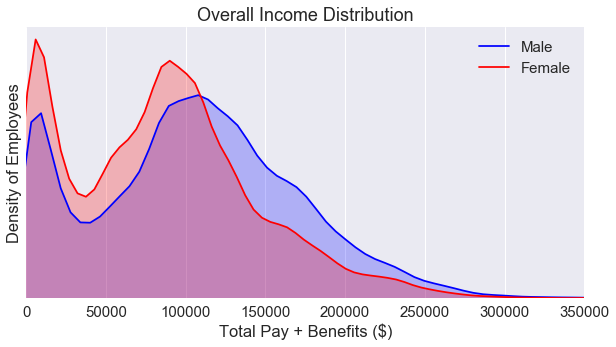

In [14]:
fig = plt.figure(figsize=(10, 5))
male_only = male_female_only[male_female_only['Gender'] == 'male']
female_only = male_female_only[male_female_only['Gender'] == 'female']


ax = sns.kdeplot(male_only['TotalPayBenefits'], color ='Blue', label='Male', shade=True)
ax = sns.kdeplot(female_only['TotalPayBenefits'], color='Red', label='Female', shade=True)

plt.yticks([])
plt.title('Overall Income Distribution')
plt.ylabel('Density of Employees')
plt.xlabel('Total Pay + Benefits ($)')
plt.xlim(0, 350000)
plt.show()

The income distribution plot is bimodal. In addition, we see a gender wage gap in favor of males in between the ~110000 and the ~275000 region. But, this plot doesn't capture the whole story. We need to break down the data some more. But first, let's explore the percentage of employees based on gender.

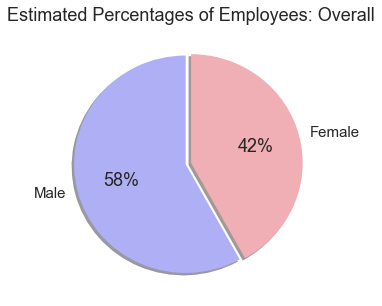

In [15]:
fig = plt.figure(figsize=(5, 5))

colors = ['#AFAFF5', '#EFAFB5']
labels = ['Male', 'Female']
sizes = [len(male_only), len(female_only)]
explode = (0.05, 0)
sns.set(font_scale=1.5)
ax = plt.pie(sizes, labels=labels, explode=explode, colors=colors, shadow=True, startangle=90, autopct='%1.f%%')

plt.title('Estimated Percentages of Employees: Overall')
plt.show()

Another key factor we have to consider is the number of employees. How do we know if there are simply more men working at higher paying jobs? How can we determine if social injustice has occured?

The chart above only tells us the total percentage of employees across all job categories, but it does give us an overview of the data.

#### 4.2 - Exploring the year column

The data set contain information on employees between 2011-2014. Let's take a look at an overview of the income based on the `Year` column regardless of gender.

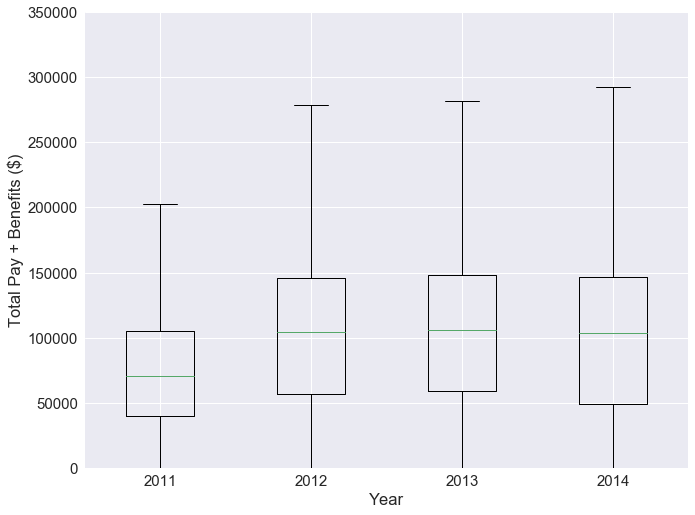

In [16]:
data_2011 = male_female_only[male_female_only['Year'] == 2011]
data_2012 = male_female_only[male_female_only['Year'] == 2012]
data_2013 = male_female_only[male_female_only['Year'] == 2013]
data_2014 = male_female_only[male_female_only['Year'] == 2014]


plt.figure(figsize=(10,7.5))
ax = plt.boxplot([data_2011['TotalPayBenefits'].values, data_2012['TotalPayBenefits'].values, \
                  data_2013['TotalPayBenefits'].values, data_2014['TotalPayBenefits'].values])
plt.ylim(0, 350000)
plt.xticks([1, 2, 3, 4], ['2011', '2012', '2013', '2014'])
plt.xlabel('Year')
plt.ylabel('Total Pay + Benefits ($)')
plt.tight_layout()

From the boxplots, we see that the total pay is increasing for every year. We'll have to consider inflation in our analysis. In addition, it is very possible for an employee to stay at their job for multiple years. We don't want to double sample on these employees. 

To simplify the data for the purpose of investigating the gender gap. It makes more sense to only choose only one year for our analysis. From our data exploration, we noticed that the majority of the `status` column was blank. Let's break the data down by year using the `.value_counts()` method.

In [17]:
years = ['2011', '2012', '2013', '2014']
all_data = [data_2011, data_2012, data_2013, data_2014]

for i in range(4):
    print(len(years[i])*'-')
    print(years[i])
    print(len(years[i])*'-')
    print(all_data[i]['Status'].value_counts())

----
2011
----
    29474
Name: Status, dtype: int64
----
2012
----
    29799
Name: Status, dtype: int64
----
2013
----
    29839
Name: Status, dtype: int64
----
2014
----
FT    18295
PT    12302
Name: Status, dtype: int64


The status of the employee is critical to our analysis, only year 2014 has this information. So it makes sense to focus on analysis on 2014. 

In [18]:
data_2014_FT = data_2014[data_2014['Status'] == 'FT']
data_2014_PT = data_2014[data_2014['Status'] == 'PT']

#### 4.3 - Full time vs. part time employees

Let's take a look at the kernal density estimation plot for part time and full time employees.

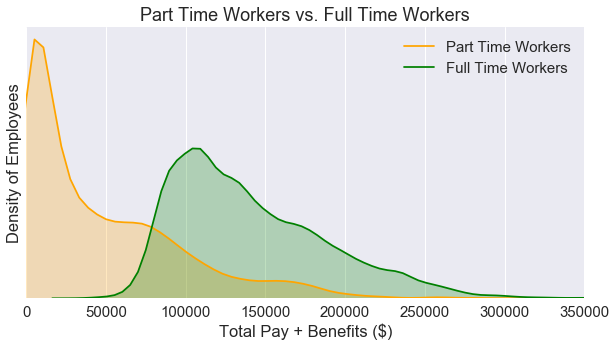

In [19]:
fig = plt.figure(figsize=(10, 5))
ax = sns.kdeplot(data_2014_PT['TotalPayBenefits'], color = 'Orange', label='Part Time Workers', shade=True)
ax = sns.kdeplot(data_2014_FT['TotalPayBenefits'], color = 'Green', label='Full Time Workers', shade=True)
plt.yticks([])

plt.title('Part Time Workers vs. Full Time Workers')
plt.ylabel('Density of Employees')
plt.xlabel('Total Pay + Benefits ($)')
plt.xlim(0, 350000)
plt.show()

If we split the data by employment status, we can see that the kernal distribution plot is no longer bimodal. Next, let's see how these two plots look if we seperate the data by gender.

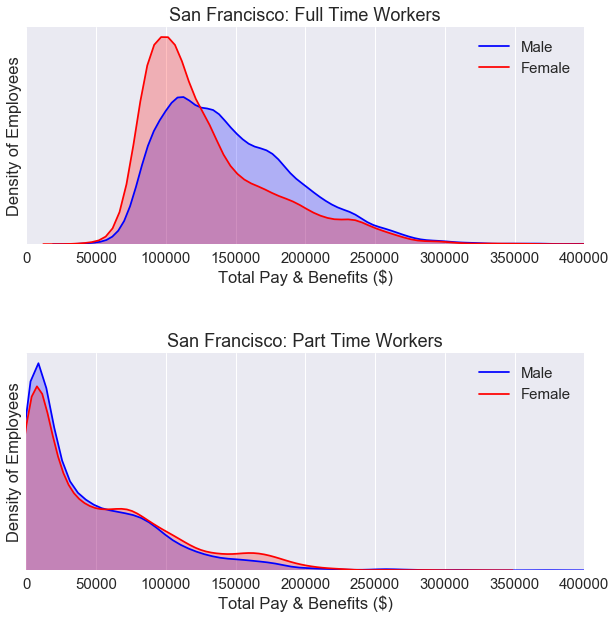

In [20]:
fig = plt.figure(figsize=(10, 10))
fig.subplots_adjust(hspace=.5)  

#Generate the top plot
male_only = data_2014_FT[data_2014_FT['Gender'] == 'male']
female_only = data_2014_FT[data_2014_FT['Gender'] == 'female']
ax = fig.add_subplot(2, 1, 1)
ax = sns.kdeplot(male_only['TotalPayBenefits'], color ='Blue', label='Male', shade=True)
ax = sns.kdeplot(female_only['TotalPayBenefits'], color='Red', label='Female', shade=True)
plt.title('San Francisco: Full Time Workers')
plt.ylabel('Density of Employees')
plt.xlabel('Total Pay & Benefits ($)')
plt.xlim(0, 400000)
plt.yticks([])

#Generate the bottom plot
male_only = data_2014_PT[data_2014_PT['Gender'] == 'male']
female_only = data_2014_PT[data_2014_PT['Gender'] == 'female']
ax2 = fig.add_subplot(2, 1, 2)
ax2 = sns.kdeplot(male_only['TotalPayBenefits'], color ='Blue', label='Male', shade=True)
ax2 = sns.kdeplot(female_only['TotalPayBenefits'], color='Red', label='Female', shade=True)
plt.title('San Francisco: Part Time Workers')
plt.ylabel('Density of Employees')
plt.xlabel('Total Pay & Benefits ($)')
plt.xlim(0, 400000)
plt.yticks([])

plt.show()

For part time workers, the KDE plot is nearly identical for both males and females.

For full time workers, we still see a gender gap. We'll need to break down the data some more.

#### 4.4 - Breaking down the total pay

We used total pay including benefits for the x-axis for the KDE plot in the previous section. Is this a fair way to analyze the data? What if men work more overtime hours than women? Can we break down the data some more?

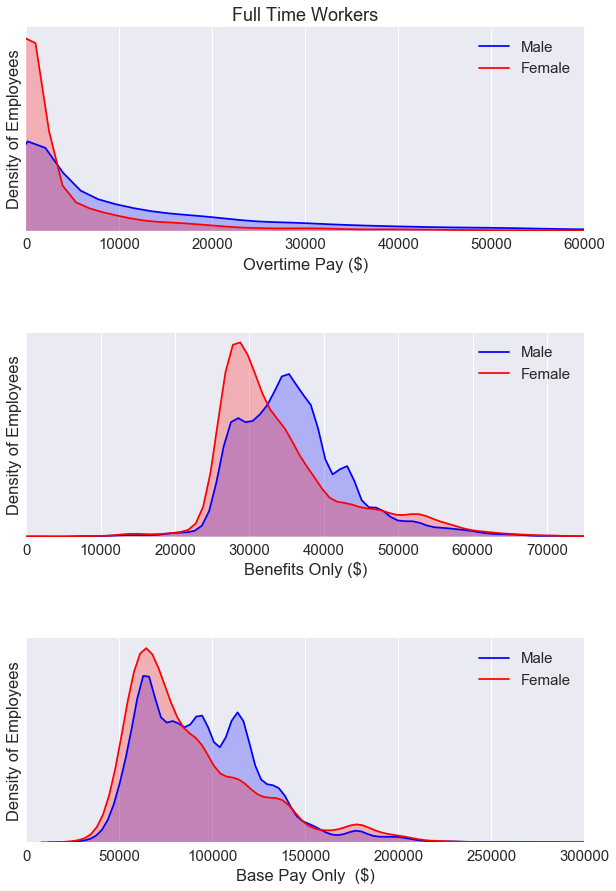

In [21]:
male_only = data_2014_FT[data_2014_FT['Gender'] == 'male']
female_only = data_2014_FT[data_2014_FT['Gender'] == 'female']

fig = plt.figure(figsize=(10, 15))
fig.subplots_adjust(hspace=.5)  

#Generate the top plot  
ax = fig.add_subplot(3, 1, 1)
ax = sns.kdeplot(male_only['OvertimePay'], color ='Blue', label='Male', shade=True)
ax = sns.kdeplot(female_only['OvertimePay'], color='Red', label='Female', shade=True)
plt.title('Full Time Workers')
plt.ylabel('Density of Employees')
plt.xlabel('Overtime Pay ($)')
plt.xlim(0, 60000)
plt.yticks([])

#Generate the middle plot
ax2 = fig.add_subplot(3, 1, 2)
ax2 = sns.kdeplot(male_only['Benefits'], color ='Blue', label='Male', shade=True)
ax2 = sns.kdeplot(female_only['Benefits'], color='Red', label='Female', shade=True)
plt.ylabel('Density of Employees')
plt.xlabel('Benefits Only ($)')
plt.xlim(0, 75000)
plt.yticks([])

#Generate the bottom plot
ax3 = fig.add_subplot(3, 1, 3)
ax3 = sns.kdeplot(male_only['BasePay'], color ='Blue', label='Male', shade=True)
ax3 = sns.kdeplot(female_only['BasePay'], color='Red', label='Female', shade=True)
plt.ylabel('Density of Employees')
plt.xlabel('Base Pay Only  ($)')
plt.xlim(0, 300000)
plt.yticks([])

plt.show()

We see a gender gap for all three plots above. Looks like we'll have to dig even deeper and analyze the data by job cateogries.

But first, let's take a look at the overall correlation for the data set.

In [22]:
data_2014_FT.corr()

,Id,BasePay,OvertimePay,OtherPay,Benefits,TotalPay,TotalPayBenefits,Year
Id,1.000000,-0.877444,-0.411121,-0.509659,-0.855170,-0.937597,-0.941414,NaN
BasePay,-0.877444,1.000000,0.093663,0.341598,0.931052,0.899297,0.921664,NaN
OvertimePay,-0.411121,0.093663,1.000000,0.461432,0.146955,0.500797,0.450542,NaN
OtherPay,-0.509659,0.341598,0.461432,1.000000,0.373868,0.593955,0.568038,NaN
Benefits,-0.855170,0.931052,0.146955,0.373868,1.000000,0.866966,0.905816,NaN
TotalPay,-0.937597,0.899297,0.500797,0.593955,0.866966,1.000000,0.996456,NaN
TotalPayBenefits,-0.941414,0.921664,0.450542,0.568038,0.905816,0.996456,1.000000,NaN
Year,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


The correlation table above uses Pearson's R to determine the values. The `BasePay` and `Benefits` column are very closely related. We can visualize this relationship using a scatter plot.

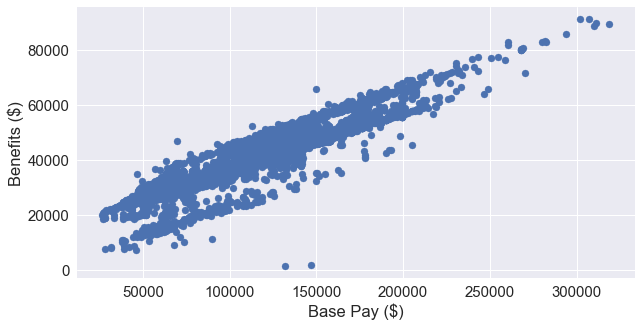

In [23]:
fig = plt.figure(figsize=(10, 5))

ax = plt.scatter(data_2014_FT['BasePay'], data_2014_FT['Benefits'])

plt.ylabel('Benefits ($)')
plt.xlabel('Base Pay ($)')

plt.show()

This makes a lot of sense because an employee's benefits is based on a percentage of their base pay. The San Francisco Human Resources department includes this information on their website [here](http://sfdhr.org/benefits-overview).

As we move further into our analysis of the data, it makes the most sense to focus on the `BasePay` column. Both `Benefits` and `OvertimePay` are dependent of the `BasePay`. 

#### 4.5 - Breaking down the base pay by job category

Next we'll analyze the base pay of full time workers by job category.

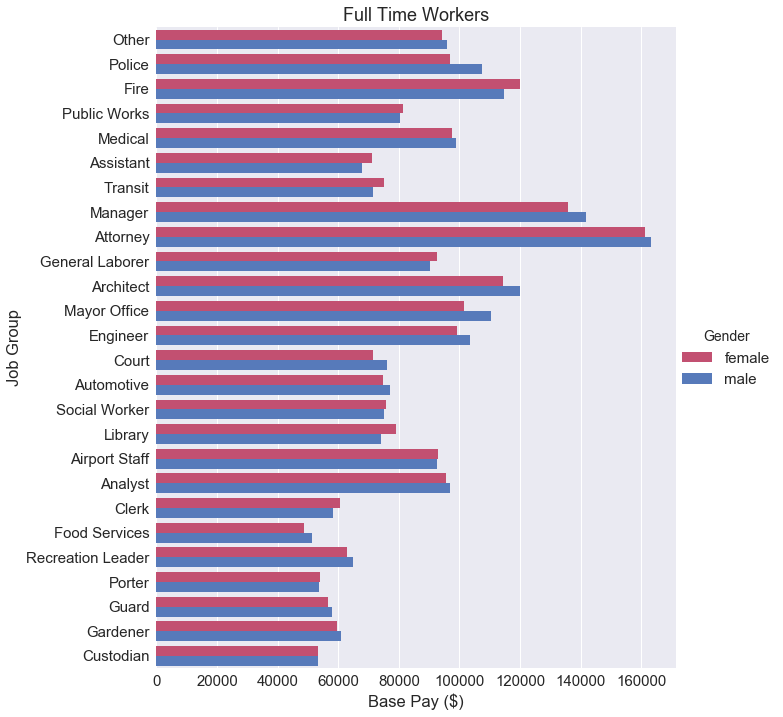

In [24]:
pal = sns.diverging_palette(0, 255, n=2)
ax = sns.factorplot(x='BasePay', y='Job_Group', hue='Gender', data=data_2014_FT,
                   size=10, kind="bar", palette=pal, ci=None)


plt.title('Full Time Workers')
plt.xlabel('Base Pay ($)')
plt.ylabel('Job Group')
plt.show()

At a glance, we can't really draw any conclusive statements about the gender wage gap. Some job categories favor females, some favor males. It really depends on what job group the employee is actually in. Maybe it makes more sense to calculate the the difference between these two bars.

In [25]:
salaries_by_group = pd.pivot_table(data = data_2014_FT, 
                                   values = 'BasePay',
                                   columns = 'Job_Group', index='Gender',
                                   aggfunc = np.mean)

count_by_group = pd.pivot_table(data = data_2014_FT, 
                                   values = 'Id',
                                   columns = 'Job_Group', index='Gender',
                                   aggfunc = len)

salaries_by_group

Job_Group,Airport Staff,Analyst,Architect,Assistant,Attorney,Automotive,Clerk,Court,Custodian,Engineer,...,Manager,Mayor Office,Medical,Other,Police,Porter,Public Works,Recreation Leader,Social Worker,Transit
Gender,,,,,,,,,,,,,,,,,,,,,
female,93049.884167,95617.613856,114343.524687,71032.503354,161300.608015,74622.464000,60660.043242,71426.702368,53371.864054,99329.591256,...,135784.930749,101367.370667,97588.758869,94135.220338,96904.757377,54082.077759,81247.921868,62936.435455,75681.812015,75090.511923
male,92446.252414,96780.843204,120101.229531,67926.254054,163313.664820,77187.707896,58414.105333,76148.568065,53336.443035,103380.709111,...,141848.676974,110323.298000,98908.448211,95980.833580,107504.600055,53561.220392,80428.692759,64989.786250,75082.064234,71361.143283


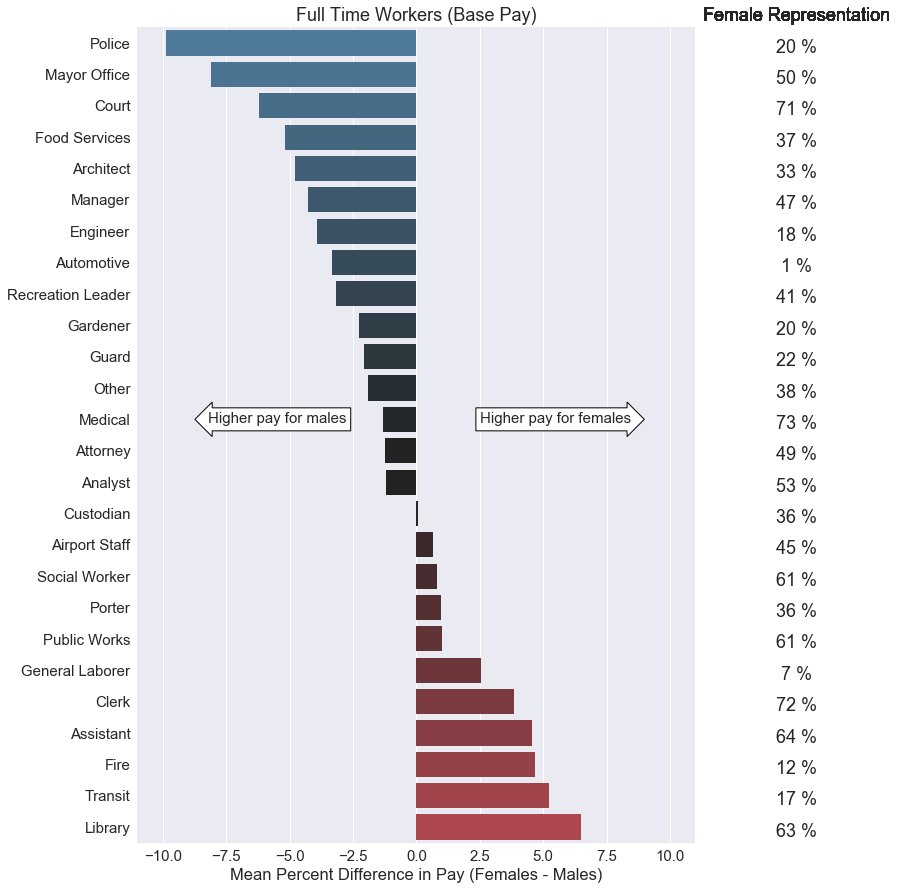

In [26]:
fig = plt.figure(figsize=(10, 15))
sns.set(font_scale=1.5)

differences = (salaries_by_group.loc['female'] - salaries_by_group.loc['male'])*100/salaries_by_group.loc['male']

labels  = differences.sort_values().index

x = differences.sort_values()
y = [i for i in range(len(differences))]
palette = sns.diverging_palette(240, 10, n=28, center ='dark')
ax = sns.barplot(x, y, orient = 'h', palette = palette)

#Draws the two arrows
bbox_props = dict(boxstyle="rarrow,pad=0.3", fc="white", ec="black", lw=1)
t = plt.text(5.5, 12, "Higher pay for females", ha="center", va="center", rotation=0,
            size=15,
            bbox=bbox_props)
bbox_props2 = dict(boxstyle="larrow,pad=0.3", fc="white", ec="black", lw=1)
t = plt.text(-5.5, 12, "Higher pay for males", ha="center", va="center", rotation=0,
            size=15,
            bbox=bbox_props2)

#Labels each bar with the percentage of females
percent_labels = count_by_group[labels].iloc[0]*100 \
                /(count_by_group[labels].iloc[0] + count_by_group[labels].iloc[1])
for i in range(len(ax.patches)):
    p = ax.patches[i]
    width = p.get_width()*1+1
    ax.text(15,
            p.get_y()+p.get_height()/2+0.3,
            '{:1.0f}'.format(percent_labels[i])+' %',
            ha="center") 
    ax.text(15, -1+0.3, 'Female Representation',
            ha="center", fontname='Arial', rotation = 0) 

    
plt.yticks(range(len(differences)), labels)
plt.title('Full Time Workers (Base Pay)')
plt.xlabel('Mean Percent Difference in Pay (Females - Males)')
plt.xlim(-11, 11)
plt.show()

I believe this is a better way to represent the gender wage gap. I calculated the mean difference between female and male pay based on job categories. Then I converted the values into a percentage by using this formula:

$$ \text{Mean Percent Difference} = \frac{\text{(Female Mean Pay - Male Mean Pay)*100}} {\text{Male Mean Pay}} $$

The theory stating that women makes 78 cents for every dollar men makes implies a 22% pay difference. None of these percentages were more than 10%, and not all of these percentage values showed favoritism towards males. However, we should keep in mind that this data set only applies to San Francisco public jobs. We should also keep in mind that we do not have access to job experience data which would directly correlate with base pay.

In addition, I included a short table of female representation for each job group on the right side of the graph. We'll dig further into this on the next section.

#### 4.6 - Gender representation by job category

In [27]:
contingency_table = pd.crosstab(
    data_2014_FT['Gender'],
    data_2014_FT['Job_Group'],
    margins = True
)
contingency_table

Job_Group,Airport Staff,Analyst,Architect,Assistant,Attorney,Automotive,Clerk,Court,Custodian,Engineer,...,Mayor Office,Medical,Other,Police,Porter,Public Works,Recreation Leader,Social Worker,Transit,All
Gender,,,,,,,,,,,,,,,,,,,,,
female,24,376,32,328,136,5,694,76,111,207,...,15,1088,1096,648,58,91,22,521,286,6501
male,29,334,64,185,139,366,270,31,201,967,...,15,408,1768,2538,102,58,32,333,1389,11794
All,53,710,96,513,275,371,964,107,312,1174,...,30,1496,2864,3186,160,149,54,854,1675,18295


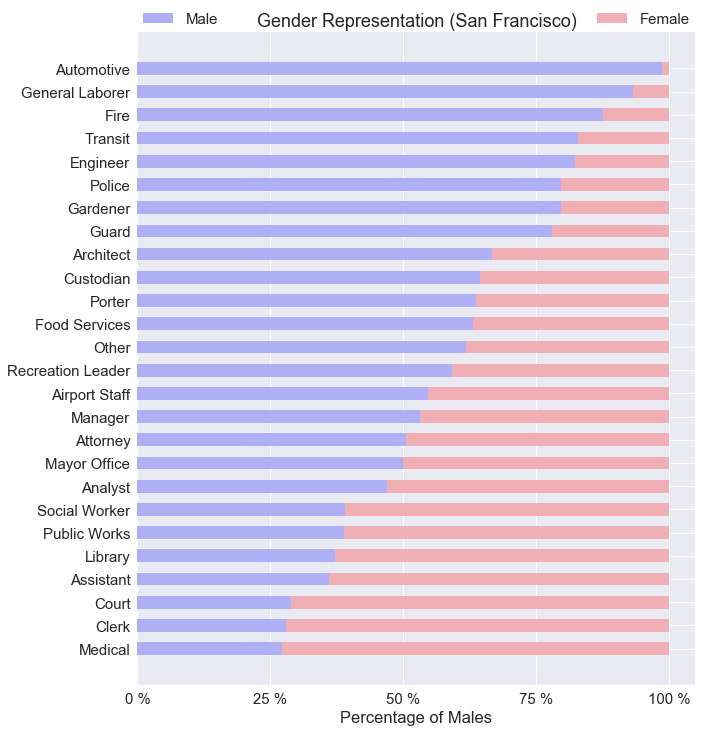

In [28]:
#Assigns the frequency values
femalecount = contingency_table.iloc[0][0:-1].values
malecount = contingency_table.iloc[1][0:-1].values

totals = contingency_table.iloc[2][0:-1]
femalepercentages = femalecount*100/totals
malepercentages = malecount*100/totals


malepercentages=malepercentages.sort_values(ascending=True)
femalepercentages=femalepercentages.sort_values(ascending=False)
length = range(len(femalepercentages))

#Plots the bar chart
fig = plt.figure(figsize=(10, 12))
sns.set(font_scale=1.5)
p1 = plt.barh(length, malepercentages.values, 0.55, label='Male', color='#AFAFF5')
p2 = plt.barh(length, femalepercentages, 0.55, left=malepercentages, color='#EFAFB5', label='Female')



labels = malepercentages.index
plt.yticks(range(len(malepercentages)), labels)
plt.xticks([0, 25, 50, 75, 100], ['0 %', '25 %', '50 %', '75 %', '100 %'])
plt.xlabel('Percentage of Males')
plt.title('Gender Representation (San Francisco)')
plt.legend(bbox_to_anchor=(0, 1, 1, 0), loc=3,
           ncol=2, mode="expand", borderaxespad=0)
plt.show()

The chart above does not include any information based on pay. I wanted to show an overview of gender representation based on job category. It is safe to say, women don't like working with automotives with <1% female representation. Where as female representation is highest for medical jobs at 73%.

#### 4.7 - Significance testing by exact job title

So what if breaking down the wage gap by job category is not good enough? Should we break down the gender gap by exact job title? Afterall, the argument is for equal pay for equal work. We can assume equal work if the job titles are exactly the same.

We can use hypothesis testing using the Welch's t-test to determine if there is a statistically significant result between male and female wages. The Welch's t-test is very robust as it doesn't assume equal variance and equal sample size. It does however, assume a normal distrbution which is well represented by the KDE plots. I talk about this in detail in my blog post [here](https://codingdisciple.com/hypothesis-testing-welch-python.html).

Let's state our null and alternative hypothesis:

$ H_0 : \text{There is no statistically significant relationship between gender and pay.}  $

$ H_a : \text{There is a statistically significant relationship between gender and pay.} $

We are going to use only job titles with more than 100 employees, and job titles with more than 30 females and 30 males for this t-test. Using a for loop, we'll perform the Welch's t-test on every job title tat matches our criteria.

In [29]:
from scipy import stats

#Significance testing by job title
job_titles = data_2014['JobTitle'].value_counts(dropna=True)
job_titles_over_100 = job_titles[job_titles > 100 ]

t_scores = {}

for title,count in job_titles_over_100.iteritems():
    male_pay = pd.to_numeric(male_only[male_only['JobTitle'] == title]['BasePay'])
    female_pay = pd.to_numeric(female_only[female_only['JobTitle'] == title]['BasePay'])
    
    if female_pay.shape[0] < 30:
        continue
    if male_pay.shape[0] < 30:
        continue

    t_scores[title] = stats.ttest_ind_from_stats(       
        mean1=male_pay.mean(), std1=(male_pay.std()), nobs1= male_pay.shape[0], \
        mean2=female_pay.mean(), std2=(female_pay.std()), nobs2=female_pay.shape[0], \
        equal_var=False)
    
for key, value in t_scores.items():
    if value[1] < 0.05:
        print(len(key)*'-')        
        print(key)
        print(len(key)*'-')
        print(t_scores[key])
        print(' ')
        print('Male: {}'.format((male_only[male_only['JobTitle'] == key]['BasePay']).mean()))
        print('sample size: {}'.format(male_only[male_only['JobTitle'] == key].shape[0]))
        print(' ')
        print('Female: {}'.format((female_only[female_only['JobTitle'] == key]['BasePay']).mean()))
        print('sample size: {}'.format(female_only[female_only['JobTitle'] == key].shape[0]))


----------------
Transit Operator
----------------
Ttest_indResult(statistic=5.20560164116152, pvalue=3.9803552807992223e-07)
 
Male: 64068.532049433576
sample size: 971
 
Female: 62491.15360215054
sample size: 186
------------
Senior Clerk
------------
Ttest_indResult(statistic=-2.5391065634795362, pvalue=0.013575306848745547)
 
Male: 51291.90378378379
sample size: 37
 
Female: 53830.58425
sample size: 120
----------
Manager II
----------
Ttest_indResult(statistic=2.4258239418558945, pvalue=0.017341194165396163)
 
Male: 121976.36624999999
sample size: 56
 
Female: 117550.0123529412
sample size: 51
----------------
Registered Nurse
----------------
Ttest_indResult(statistic=-3.7087643141584667, pvalue=0.00033539561477398915)
 
Male: 128033.80955882354
sample size: 68
 
Female: 132992.0894059406
sample size: 202
------------------------------
Community Police Services Aide
------------------------------
Ttest_indResult(statistic=2.1634922455155117, pvalue=0.03368488556993355)
 
Male: 64

In [30]:
len(t_scores)

25

Out of the 25 jobs that were tested using the Welch's t-test, 5 jobs resulted in a p-value of less than 0.05. However, not all jobs showed favoritism towards males. 'Registered Nurse' and 'Senior Clerk' both showed an average pay in favor of females. However, we should take the Welch's t-test results with a grain of salt. We do not have data on the work experience of the employees. Maybe female nurses have more work experience over males. Maybe male transit operators have more work experience over females. We don't actually know. Since `BasePay` is a function of work experience, without this critical piece of information, we can not make any conclusions based on the t-test alone. All we know is that a statistically significant difference exists.

### 5.0 - San Francisco vs. Newport Beach

Let's take a look at more a more conservative city such as Newport Beach. This data can be downloaded at Transparent California [here](https://transparentcalifornia.com/salaries/2016/newport-beach/).

We can process the data similar to the San Francisco data set. The following code performs the following:

+ Read the data using pandas
+ Create the `Job_Group` column
+ Create the `Gender` column
+ Create two new dataframes: one for part time workers and one for full time workers

In [31]:
#Reads in the data
nb_data = pd.read_csv('newport-beach-2016.csv')

#Creates job groups
def find_job_title_nb(row):
    titles = collections.OrderedDict([
        ('Police',['police', 'sherif', 'probation', 'sergeant', 'officer', 'lieutenant']),
        ('Fire', ['fire']),
        ('Transit',['mta', 'transit']),
        ('Medical',['anesth', 'medical', 'nurs', 'health', 'physician', 'orthopedic', 'pharm', 'care']),
        ('Architect', ['architect']),
        ('Court',['court', 'legal']),
        ('Mayor Office', ['mayoral']),
        ('Library', ['librar']),
        ('Public Works', ['public']),
        ('Attorney', ['attorney']),
        ('Custodian', ['custodian']),
        ('Gardener', ['garden']),
        ('Recreation Leader', ['recreation']),
        ('Automotive',['automotive', 'mechanic', 'truck']),
        ('Engineer',['engineer', 'engr', 'eng', 'program']),
        ('General Laborer',['general laborer', 'painter', 'inspector', 'carpenter', 'electrician', 'plumber', 'maintenance']),
        ('Food Services', ['food serv']),
        ('Clerk', ['clerk']),
        ('Porter', ['porter']),
        ('Airport Staff', ['airport']),
        ('Social Worker',['worker']),        
        ('Guard', ['guard']),
        ('Assistant',['aide', 'assistant', 'secretary', 'attendant']),        
        ('Analyst', ['analy']),
        ('Manager', ['manager'])      
    ])       
         
    #Loops through the dictionaries
    for group, keywords in titles.items():
        for keyword in keywords:
            if keyword in row.lower():
                return group
    return 'Other'

start_time = time.time()    
nb_data["Job_Group"]=data["JobTitle"].map(find_job_title_nb)

#Create the 'Gender' column based on employee's first name.
d = gender.Detector(case_sensitive=False)
nb_data['FirstName'] = nb_data['Employee Name'].str.split().apply(lambda x: x[0])
nb_data['Gender'] = nb_data['FirstName'].apply(lambda x: d.get_gender(x))
nb_data['Gender'].value_counts()

#Retain data with 'male' and 'female' names.
nb_male_female_only = nb_data[(nb_data['Gender'] == 'male') | (nb_data['Gender'] == 'female')]
nb_male_female_only['Gender'].value_counts()

#Seperates full time/part time data
nb_data_FT = nb_male_female_only[nb_male_female_only['Status'] == 'FT']
nb_data_PT = nb_male_female_only[nb_male_female_only['Status'] == 'PT']

nb_data_FT.head()

,Employee Name,Job Title,Base Pay,Overtime Pay,Other Pay,Benefits,Total Pay,Total Pay & Benefits,Year,Notes,Agency,Status,Job_Group,FirstName,Gender
0,Scott Poster,FIRE CHIEF,228067.56,0.00,57289.33,145114.67,285356.89,430471.56,2016,NaN,Newport Beach,FT,Transit,Scott,male
1,Charles Duncan,FIRE ASSISTANT CHIEF,197131.52,0.00,44747.91,144994.50,241879.43,386873.93,2016,NaN,Newport Beach,FT,Police,Charles,male
2,Ty Lunde,FIRE CAPTAIN + 7.5%,118806.31,130011.25,30486.04,106032.23,279303.60,385335.83,2016,NaN,Newport Beach,FT,Police,Ty,male
3,Jon Lewis,POLICE CHIEF,208498.34,0.00,29679.40,118476.62,238177.74,356654.36,2016,NaN,Newport Beach,FT,Automotive,Jon,male
4,David Kiff,CITY MANAGER,262652.38,0.00,13067.92,77488.07,275720.30,353208.37,2016,NaN,Newport Beach,FT,Fire,David,male


#### 5.1 - Part time vs. full time workers

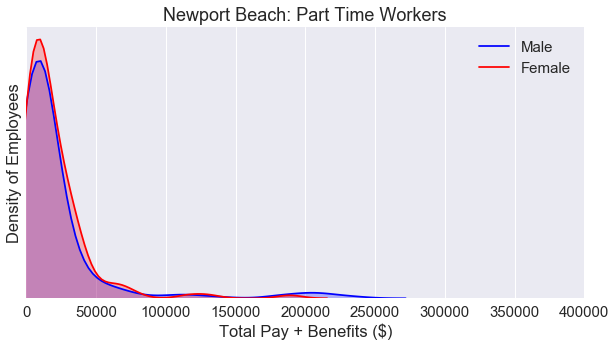

In [32]:
fig = plt.figure(figsize=(10, 5))

nb_male_only = nb_data_PT[nb_data_PT['Gender'] == 'male']
nb_female_only = nb_data_PT[nb_data_PT['Gender'] == 'female']
ax = fig.add_subplot(1, 1, 1)
ax = sns.kdeplot(nb_male_only['Total Pay & Benefits'], color ='Blue', label='Male', shade=True)
ax = sns.kdeplot(nb_female_only['Total Pay & Benefits'], color='Red', label='Female', shade=True)
plt.title('Newport Beach: Part Time Workers')
plt.ylabel('Density of Employees')
plt.xlabel('Total Pay + Benefits ($)')
plt.xlim(0, 400000)
plt.yticks([])

plt.show()

Similar to the KDE plot for San Francisco, the KDE plot is nearly identical for both males and females for part time workers.

Let's take a look at the full time workers.

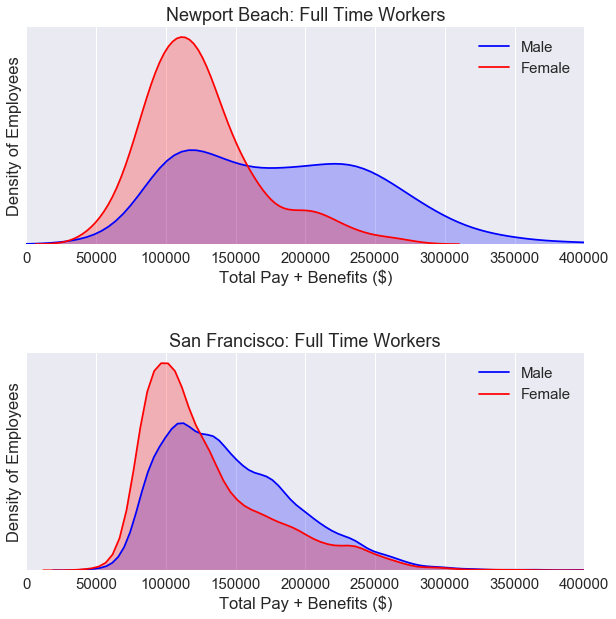

In [33]:
fig = plt.figure(figsize=(10, 10))
fig.subplots_adjust(hspace=.5)  

#Generate the top chart
nb_male_only = nb_data_FT[nb_data_FT['Gender'] == 'male']
nb_female_only = nb_data_FT[nb_data_FT['Gender'] == 'female']
ax = fig.add_subplot(2, 1, 1)
ax = sns.kdeplot(nb_male_only['Total Pay & Benefits'], color ='Blue', label='Male', shade=True)
ax = sns.kdeplot(nb_female_only['Total Pay & Benefits'], color='Red', label='Female', shade=True)
plt.title('Newport Beach: Full Time Workers')
plt.ylabel('Density of Employees')
plt.xlabel('Total Pay + Benefits ($)')
plt.xlim(0, 400000)
plt.yticks([])

#Generate the bottom chart
male_only = data_2014_FT[data_2014_FT['Gender'] == 'male']
female_only = data_2014_FT[data_2014_FT['Gender'] == 'female']
ax2 = fig.add_subplot(2, 1, 2)
ax2 = sns.kdeplot(male_only['TotalPayBenefits'], color ='Blue', label='Male', shade=True)
ax2 = sns.kdeplot(female_only['TotalPayBenefits'], color='Red', label='Female', shade=True)
plt.title('San Francisco: Full Time Workers')
plt.ylabel('Density of Employees')
plt.xlabel('Total Pay + Benefits ($)')
plt.xlim(0, 400000)
plt.yticks([])

plt.show()

The kurtosis of the KDE plot for Newport Beach full time workers is lower than KDE plot for San Francisco full time workers. We can see a higher gender wage gap for Newport beach workers than San Francisco workers. However, these two plots do not tell us the full story. We need to break down the data by job category.

#### 5.2 - Comparisons by job cateogry

In [34]:
nb_salaries_by_group = pd.pivot_table(data = nb_data_FT, 
                                   values = 'Base Pay',
                                   columns = 'Job_Group', index='Gender',
                                   aggfunc = np.mean,)

nb_salaries_by_group

Job_Group,Assistant,Attorney,Automotive,Engineer,Fire,General Laborer,Manager,Medical,Other,Police,Public Works,Transit
Gender,,,,,,,,,,,,
female,NaN,70139.559524,NaN,NaN,76448.505882,NaN,114664.376667,85279.764286,82460.784211,78270.252857,NaN,82686.25500
male,123162.972,75404.094000,114410.966667,63998.7,99360.982205,86154.174286,94423.185000,102067.444857,105185.938529,96273.211111,135033.84,99279.03913


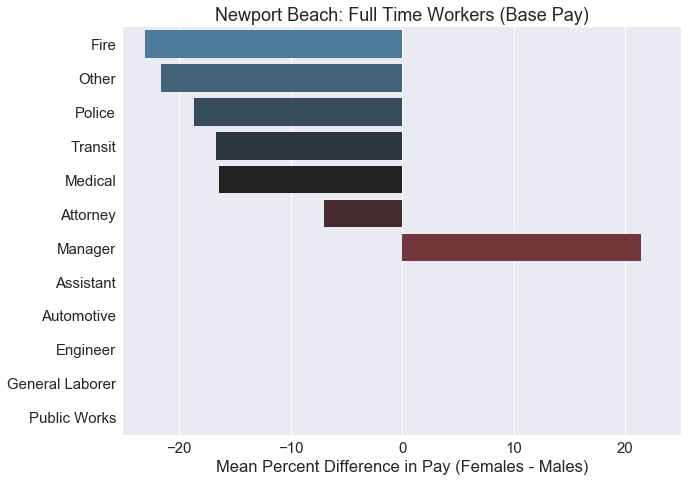

In [35]:
fig = plt.figure(figsize=(10, 7.5))
sns.set(font_scale=1.5)

differences = (nb_salaries_by_group.loc['female'] - nb_salaries_by_group.loc['male'])*100/nb_salaries_by_group.loc['male']
nb_labels  = differences.sort_values().index
x = differences.sort_values()
y = [i for i in range(len(differences))]
nb_palette = sns.diverging_palette(240, 10, n=9, center ='dark')
ax = sns.barplot(x, y, orient = 'h', palette = nb_palette)


plt.yticks(range(len(differences)), nb_labels)
plt.title('Newport Beach: Full Time Workers (Base Pay)')
plt.xlabel('Mean Percent Difference in Pay (Females - Males)')
plt.xlim(-25, 25)
plt.show()

Most of these jobs shows a higher average pay for males. The only job category where females were paid higher on average was 'Manager'. Some of these job categories do not even have a single female within the category, so the difference cannot be calculated. We should create a contingency table to check the sample size of our data.

#### 5.3 - Gender representation by job category

In [36]:
nb_contingency_table = pd.crosstab(
    nb_data_FT['Gender'],
    nb_data_FT['Job_Group'],
    margins = True
)
nb_contingency_table

Job_Group,Assistant,Attorney,Automotive,Engineer,Fire,General Laborer,Manager,Medical,Other,Police,Public Works,Transit,All
Gender,,,,,,,,,,,,,
female,0,21,0,0,34,0,3,28,19,49,0,4,158
male,5,20,3,1,127,7,16,70,34,126,1,23,433
All,5,41,3,1,161,7,19,98,53,175,1,27,591


The number of public jobs is much lower in Newport Beach compared to San Francisco. With only 3 female managers working full time in Newport Beach, we can't really say female managers make more money on average than male managers.

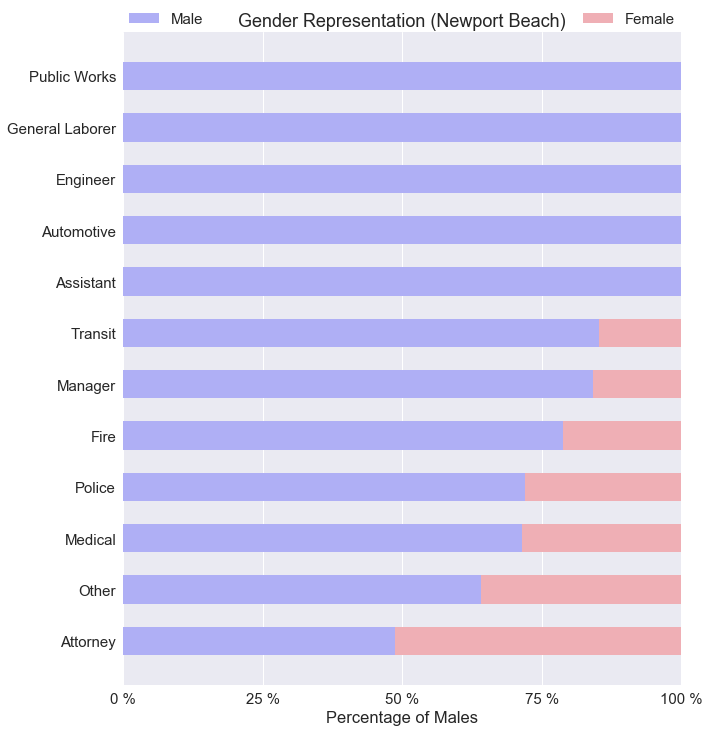

In [37]:
#Assigns the frequency values
nb_femalecount = nb_contingency_table.iloc[0][0:-1].values
nb_malecount = nb_contingency_table.iloc[1][0:-1].values

nb_totals = nb_contingency_table.iloc[2][0:-1]
nb_femalepercentages = nb_femalecount*100/nb_totals
nb_malepercentages = nb_malecount*100/nb_totals


nb_malepercentages=nb_malepercentages.sort_values(ascending=True)
nb_femalepercentages=nb_femalepercentages.sort_values(ascending=False)
nb_length = range(len(nb_malepercentages))

#Plots the bar chart
fig = plt.figure(figsize=(10, 12))
sns.set(font_scale=1.5)
p1 = plt.barh(nb_length, nb_malepercentages.values, 0.55, label='Male', color='#AFAFF5')
p2 = plt.barh(nb_length, nb_femalepercentages, 0.55, left=nb_malepercentages, color='#EFAFB5', label='Female')
labels = nb_malepercentages.index
plt.yticks(range(len(nb_malepercentages)), labels)
plt.xticks([0, 25, 50, 75, 100], ['0 %', '25 %', '50 %', '75 %', '100 %'])
plt.xlabel('Percentage of Males')
plt.title('Gender Representation (Newport Beach)')
plt.legend(bbox_to_anchor=(0, 1, 1, 0), loc=3,
           ncol=2, mode="expand", borderaxespad=0)
plt.show()

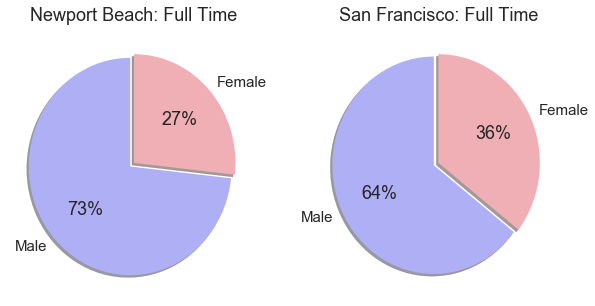

In [38]:
fig = plt.figure(figsize=(10, 5))

colors = ['#AFAFF5', '#EFAFB5']
labels = ['Male', 'Female']
sizes = [len(nb_male_only), len(nb_female_only)]
explode = (0.05, 0)
sns.set(font_scale=1.5)
ax = fig.add_subplot(1, 2, 1)
ax = plt.pie(sizes, labels=labels, explode=explode, colors=colors, shadow=True, startangle=90, autopct='%1.f%%')
plt.title('Newport Beach: Full Time')


sizes = [len(male_only), len(female_only)]
explode = (0.05, 0)
sns.set(font_scale=1.5)
ax2 = fig.add_subplot(1, 2, 2)
ax2 = plt.pie(sizes, labels=labels, explode=explode, colors=colors, shadow=True, startangle=90, autopct='%1.f%%')
plt.title('San Francisco: Full Time')

plt.show()

Looking at the plots above. There are fewer females working full time public jobs in Newport Beach compared to San Francisco. 

### 6.0 - Conclusion

It is very easy for people to say there is a gender wage gap and make general statements about it. But the real concern is whether if there is social injustice and discrimination involved. Yes, there is an overall gender wage gap for both San Francisco and Newport Beach. In both cases, the income distribution for part time employees were nearly identical for both males and females.

For full time public positions in San Francisco, an overall gender wage gap can be observed. When the full time positions were broken down to job categories, the gender wage gap went both ways. Some jobs favored men, some favored women. For full time public positions in Newport Beach, the majority of the jobs favored men.

However, we were missing a critical piece of information in this entire analysis. We don't have any information on the job experience of the employees. Maybe the men just had more job experience in Newport Beach, we don't actually know. For San Francisco, we assumed equal experience by comparing employees with the same exact job titles. Only job titles with a size greater than 100 were chosen. Out of the 25 job titles that were selected, 5 of them showed a statistically significant result with the Welch's t-test. Two of those jobs showed an average base pay in favor of females.

Overall, I do not believe the '78 cents to a dollar' is a fair statement. It generalizes the data and oversimplifies the problem. There are many hidden factors that is not shown by the data. Maybe women are less likely to ask for a promotion. Maybe women perform really well in the medical world. Maybe the men's body is more suitable for the police officer role. Maybe women are more organized than men and make better libarians. The list goes on and on, the point is, we should always be skeptical of what the numbers tell us. The truth is, men and women are different on a fundamental level. Social injustices and gender discrimination should be analyzed on a case by case basis. 